# NARSAD Trial Tracking Analysis

This notebook demonstrates the trial grouping and contrast generation functions from `first_level_workflows.py` using real NARSAD event data.

## Overview
- **Trial Grouping**: Separates first trials from subsequent trials for CS-, CSS, and CSR conditions
- **Contrast Generation**: Creates 9 interesting contrasts for fMRI analysis
- **Visualization**: Shows design matrix, trial timeline, and contrast matrix
- **Data Source**: Real NARSAD event files from `/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav`


In [105]:
# Import libraries and configure environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Configure matplotlib for notebook display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

# Add path to import from first_level_workflows
sys.path.append('/Users/xiaoqianxiao/PycharmProjects/hyak_narsad_remove')
from first_level_workflows import extract_cs_conditions, create_interesting_contrasts

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 1. Load NARSAD Event Data

Load the real NARSAD event files for Phase 2 and Phase 3.


In [106]:
# Load NARSAD event files
behav_dir = '/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav'
phase2_df = pd.read_csv(os.path.join(behav_dir, 'task-Narsad_phase2_events.csv'))
phase3_df = pd.read_csv(os.path.join(behav_dir, 'task-Narsad_phase3_events.csv'))

print(f"📊 Phase 2: {len(phase2_df)} trials")
print(f"📊 Phase 3: {len(phase3_df)} trials")
print(f"\n🔍 Phase 2 trial types: {sorted(phase2_df['trial_type'].unique())}")
print(f"🔍 Phase 3 trial types: {sorted(phase3_df['trial_type'].unique())}")

# Display sample data
print("\n📋 Sample Phase 2 data:")
print(phase2_df.head())


📊 Phase 2: 63 trials
📊 Phase 3: 52 trials

🔍 Phase 2 trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'US_CSR', 'US_CSS']
🔍 Phase 3 trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'SHOCK']

📋 Sample Phase 2 data:
   onset  duration trial_type
0      0        12   FIXATION
1     12         6        CS-
2     18        13   FIXATION
3     31         6        CSS
4     37         0     US_CSS


## 2. Process Data and Generate Contrasts

Use the functions from `first_level_workflows.py` to group trials and create contrasts.


In [107]:
# Process Phase 2 data
print("🔄 Processing Phase 2 data...")
phase2_processed, phase2_condition_names, phase2_contrast_conditions, phase2_contrasts, phase2_df_trial_info = extract_cs_conditions(phase2_df)
phase2_interesting_contrasts, phase2_contrast_names, phase2_contrast_descriptions, phase2_contrast_conditions, phase2_contrast_weights = create_interesting_contrasts(phase2_df)

print(f"✅ Phase 2: {len(phase2_processed['conditions'].unique())} conditions, {len(phase2_interesting_contrasts)} contrasts")

# Process Phase 3 data
print("\n🔄 Processing Phase 3 data...")
phase3_processed, phase3_condition_names, phase3_contrast_conditions, phase3_contrasts, phase3_df_trial_info = extract_cs_conditions(phase3_df)
phase3_interesting_contrasts, phase3_contrast_names, phase3_contrast_descriptions, phase3_contrast_conditions, phase3_contrast_weights = create_interesting_contrasts(phase3_df)

print(f"✅ Phase 3: {len(phase3_processed['conditions'].unique())} conditions, {len(phase3_interesting_contrasts)} contrasts")

# Display condition summary
print("\n📋 Condition Summary:")
print(f"Phase 2 conditions: {sorted(phase2_processed['conditions'].unique())}")
print(f"Phase 3 conditions: {sorted(phase3_processed['conditions'].unique())}")


INFO:first_level_workflows:Using DataFrame input with 63 trials
INFO:first_level_workflows:DataFrame columns: ['onset', 'duration', 'trial_type', 'conditions']
INFO:first_level_workflows:CS- conditions: first trial at index 1, 7 others
INFO:first_level_workflows:CSS conditions: first trial at index 3, 7 others
INFO:first_level_workflows:CSR conditions: first trial at index 6, 7 others
INFO:first_level_workflows:Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
INFO:first_level_workflows:Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
INFO:first_level_workflows:Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']
INFO:first_level_workflows:Using DataFrame input with 63 trials
INFO:first_level_workflows:DataFrame columns: ['onset', 'duration', 'trial_type

🔄 Processing Phase 2 data...
✅ Phase 2: 9 conditions, 9 contrasts

🔄 Processing Phase 3 data...
✅ Phase 3: 8 conditions, 9 contrasts

📋 Condition Summary:
Phase 2 conditions: ['CS-_first', 'CS-_others', 'CSR_first', 'CSR_others', 'CSS_first', 'CSS_others', 'FIXATION', 'US_CSR', 'US_CSS']
Phase 3 conditions: ['CS-_first', 'CS-_others', 'CSR_first', 'CSR_others', 'CSS_first', 'CSS_others', 'FIXATION', 'SHOCK']


## 3. Visualization Functions

Create comprehensive design matrix visualizations.


In [108]:
def create_design_matrix_viz(df_processed, contrasts, title):
    """Create a comprehensive 2x2 design matrix visualization"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    unique_conditions = df_processed['conditions'].unique()
    condition_counts = {cond: len(df_processed[df_processed['conditions'] == cond]) 
                       for cond in unique_conditions}
    
    # 1. Condition counts (bar chart)
    conditions = list(condition_counts.keys())
    counts = list(condition_counts.values())
    bars = ax1.bar(range(len(conditions)), counts, color='skyblue', alpha=0.7)
    ax1.set_title('Trial Counts per Condition', fontweight='bold')
    ax1.set_xticks(range(len(conditions)))
    ax1.set_xticklabels(conditions, rotation=45, ha='right')
    ax1.set_ylabel('Number of Trials')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                str(count), ha='center', va='bottom', fontweight='bold')
    
    # 2. Trial timeline
    y_pos = 0
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_conditions)))
    
    for i, condition in enumerate(sorted(unique_conditions)):
        condition_trials = df_processed[df_processed['conditions'] == condition]
        for _, trial in condition_trials.iterrows():
            ax2.barh(y_pos, trial['duration'], left=trial['onset'], 
                    height=0.8, alpha=0.7, color=colors[i], label=condition if y_pos == 0 else "")
        y_pos += 1
    
    ax2.set_title('Trial Timeline', fontweight='bold')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Conditions')
    ax2.set_yticks(range(len(unique_conditions)))
    ax2.set_yticklabels(sorted(unique_conditions))
    ax2.grid(True, alpha=0.3)
    
    # 3. Contrast matrix heatmap
    contrast_matrix = []
    contrast_names = []
    
    for name, _, conditions, weights in contrasts:
        contrast_names.append(name)
        contrast_row = []
        for condition in sorted(unique_conditions):
            if condition in conditions:
                weight_idx = conditions.index(condition)
                contrast_row.append(weights[weight_idx])
            else:
                contrast_row.append(0)
        contrast_matrix.append(contrast_row)
    
    contrast_matrix = np.array(contrast_matrix)
    im = ax3.imshow(contrast_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    ax3.set_xticks(range(len(sorted(unique_conditions))))
    ax3.set_xticklabels(sorted(unique_conditions), rotation=45, ha='right')
    ax3.set_yticks(range(len(contrast_names)))
    ax3.set_yticklabels(contrast_names)
    ax3.set_title('Contrast Matrix', fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
    cbar.set_label('Contrast Weight', rotation=270, labelpad=20)
    
    # Add text annotations for non-zero weights
    for i in range(len(contrast_names)):
        for j in range(len(sorted(unique_conditions))):
            weight = contrast_matrix[i, j]
            if weight != 0:
                ax3.text(j, i, f'{weight:.0f}', ha='center', va='center', 
                        color='white' if abs(weight) > 0.5 else 'black', 
                        fontweight='bold', fontsize=10)
    
    # 4. Summary statistics
    ax4.axis('off')
    
    first_trials = [c for c in unique_conditions if '_first' in c]
    other_trials = [c for c in unique_conditions if '_others' in c]
    baseline = [c for c in unique_conditions if c == 'FIXATION']
    other_conditions = [c for c in unique_conditions if '_first' not in c and '_others' not in c and c != 'FIXATION']
    
    summary = f"""📊 ANALYSIS SUMMARY

🔢 Total Conditions: {len(unique_conditions)}
🔢 Total Trials: {len(df_processed)}
🔢 Total Contrasts: {len(contrasts)}

📋 CONDITION GROUPS:
• First Trials: {len(first_trials)} ({', '.join(first_trials)})
• Other Trials: {len(other_trials)} ({', '.join(other_trials)})
• Baseline: {len(baseline)} ({', '.join(baseline)})
• Other: {len(other_conditions)} ({', '.join(other_conditions)})

🎯 CONTRAST TYPES:
• First vs Others: {len([c for c in contrasts if 'first_vs_others' in c[0]])}
• Others vs First: {len([c for c in contrasts if 'others_vs_first' in c[0]])}
• First vs Baseline: {len([c for c in contrasts if 'first_vs_baseline' in c[0]])}
• Others vs Baseline: {len([c for c in contrasts if 'others_vs_baseline' in c[0]])}
• Others vs Others: {len([c for c in contrasts if 'others_vs_others' in c[0]])}"""
    
    ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    return fig

print("✅ Visualization function created")


✅ Visualization function created


## 4. Generate Visualizations

Create and save design matrix visualizations for both phases.


🎨 Creating Phase 2 Design Matrix Visualization...
🎨 Creating Phase 3 Design Matrix Visualization...


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from current font.
  plt.tight_layout()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  plt.tight_layout()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2630222962.py:109: UserWarning: Glyph 128290 (\N{


✅ Figures saved:
  📁 phase2_design_matrix.png
  📁 phase3_design_matrix.png


/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/xiaoqianxiao/fsl/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


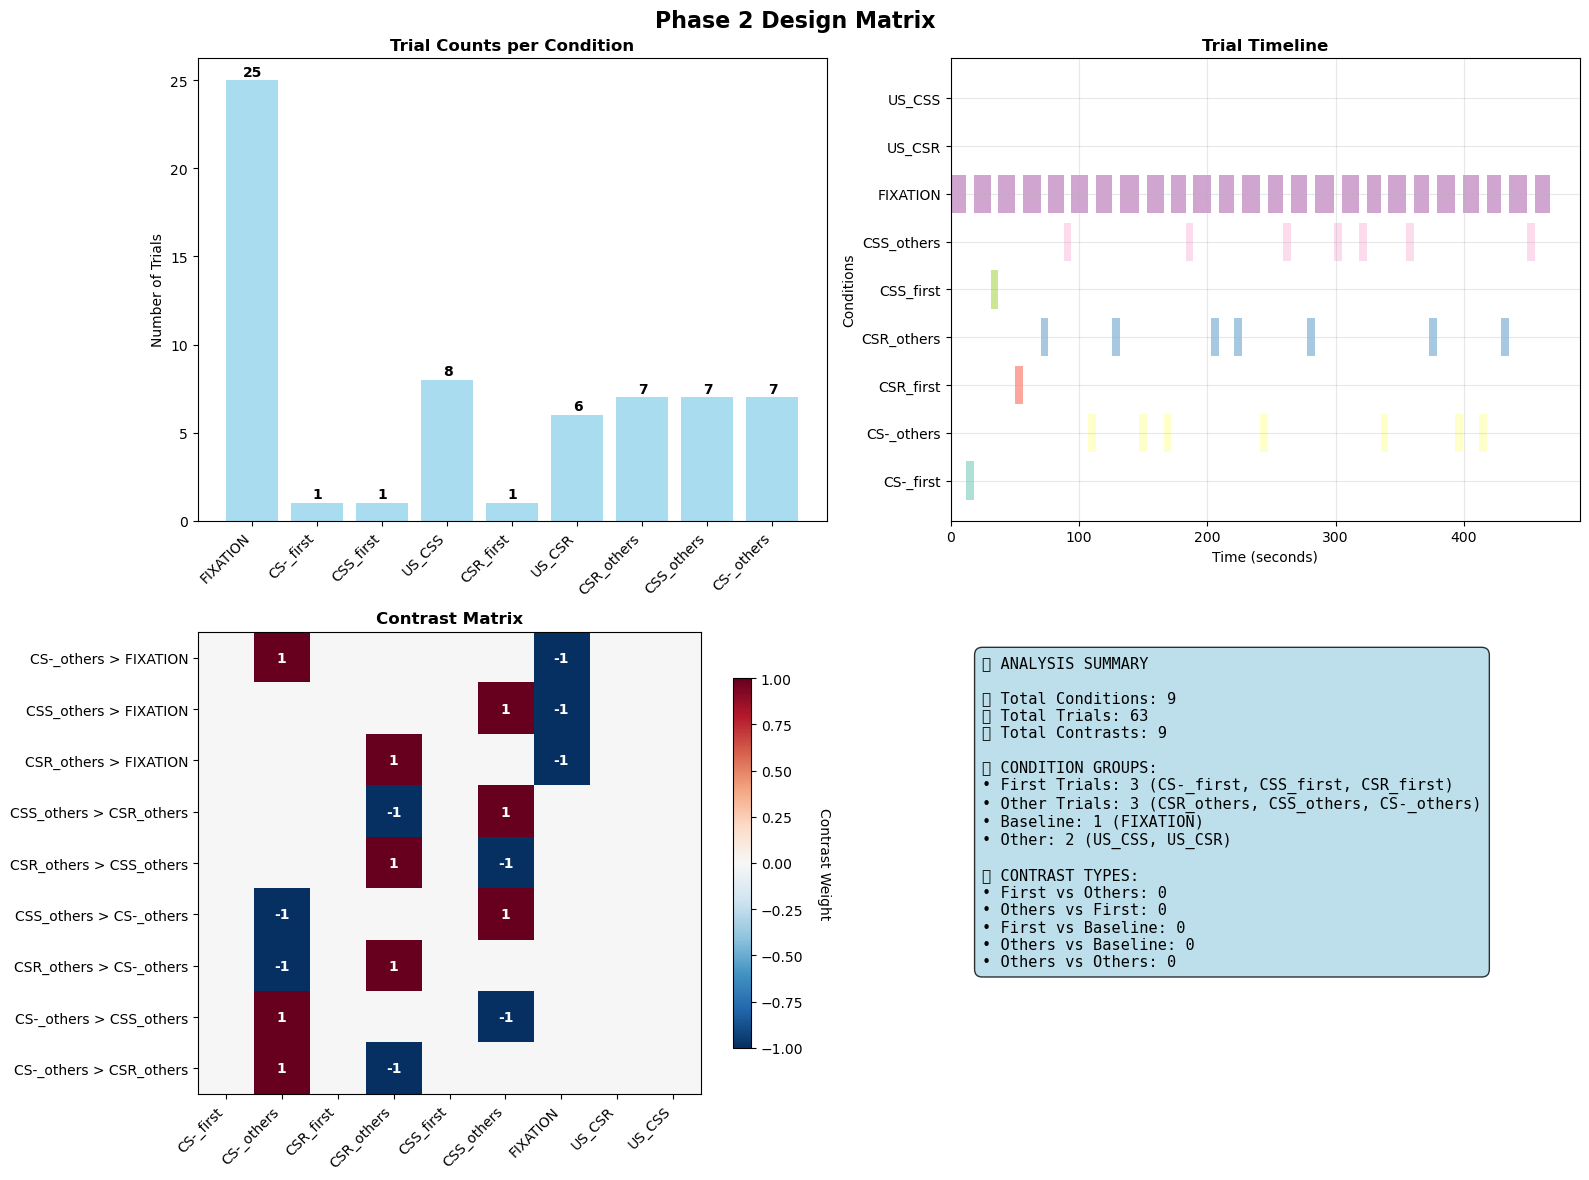

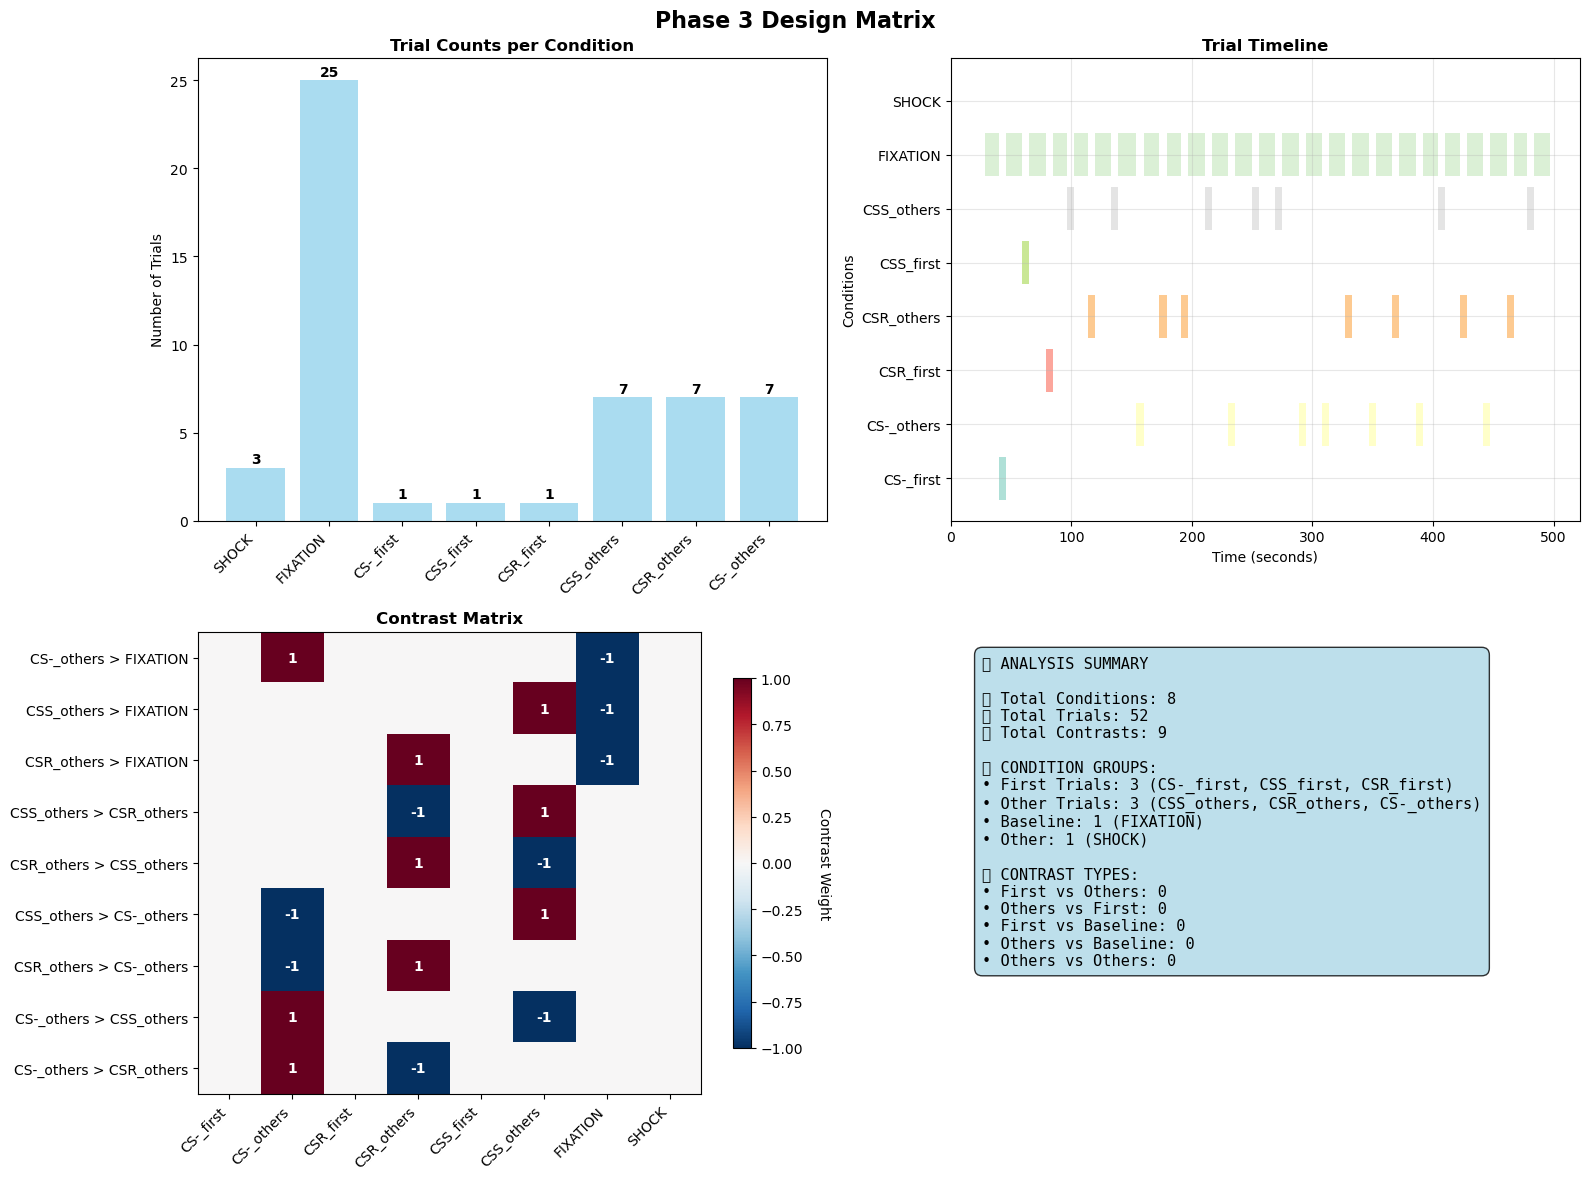


🎉 Analysis complete!


In [109]:
# Create Phase 2 visualization
print("🎨 Creating Phase 2 Design Matrix Visualization...")
fig1 = create_design_matrix_viz(phase2_processed, phase2_interesting_contrasts, "Phase 2 Design Matrix")

# Create Phase 3 visualization
print("🎨 Creating Phase 3 Design Matrix Visualization...")
fig2 = create_design_matrix_viz(phase3_processed, phase3_interesting_contrasts, "Phase 3 Design Matrix")

# Save figures to files
fig1.savefig('phase2_design_matrix.png', dpi=150, bbox_inches='tight')
fig2.savefig('phase3_design_matrix.png', dpi=150, bbox_inches='tight')

print("\n✅ Figures saved:")
print("  📁 phase2_design_matrix.png")
print("  📁 phase3_design_matrix.png")

# Display figures
plt.show()
print("\n🎉 Analysis complete!")


## 5. Summary

This analysis demonstrates:

1. **Trial Grouping**: CS-, CSS, and CSR trials are separated into 'first' and 'others' categories
2. **Contrast Generation**: 9 interesting contrasts are created for fMRI analysis
3. **Design Matrix**: Visual representation of how conditions map to regressors
4. **Timeline**: Shows when each condition occurs during the experiment

The generated contrasts can be used directly in the fMRI analysis pipeline via `first_level_workflows.py`.
